# Wrangling

In [31]:
import pandas as pd
from langchain.document_loaders.csv_loader import CSVLoader

# Trying without the transcrits
meditation_df = pd.read_csv('meditation_descriptions.csv')
meditation_df.rename(columns={'Link on server': 'link'}, inplace=True)
meditation_df.drop(columns=['Transcrit']).to_csv('meditation_descriptions_modified.csv')
meditation_df


loader = CSVLoader(file_path='meditation_descriptions_modified.csv', source_column='Meditation Title', metadata_columns=['link'])
data = loader.load()
data

[Document(page_content=': 0\nMeditation Title: Feel balanced\nTags: tired, bored, stressed, overwhelmed, demotivated, overactive, balanced, excited, anxious\nDescription: This is a balancing meditation, meant to bring someone into a state of balance and help with feeling any kind of distress and imbalance.', metadata={'source': 'Feel balanced', 'row': 0, 'link': 'https://media.sydevelopers.com/meditations/15/edit'}),
 Document(page_content=': 1\nMeditation Title: Re-kindle inner joy, evening\nTags: sad, evening\nDescription: This is an evening meditation for someone who is generally feeling down and sad emotionally. It is meant to bring a sense of relief and joy inside, and chase away any negative and depressive thoughts.', metadata={'source': 'Re-kindle inner joy, evening', 'row': 1, 'link': 'https://media.sydevelopers.com/meditations/66/edit'}),
 Document(page_content=': 2\nMeditation Title: Morning meditation\nTags: general, happy, relaxed, content, morning, morning-general\nDescrip

In [47]:
import pandas as pd
from langchain.document_loaders.csv_loader import CSVLoader
from langchain.vectorstores.faiss import FAISS
from langchain.embeddings.openai import OpenAIEmbeddings

loader = CSVLoader(file_path='meditation_descriptions_scrapped.csv', metadata_columns=['index', 'data_url'])
data = loader.load()

embeddings = OpenAIEmbeddings()

db = FAISS.from_documents(data, embedding=embeddings)
db.save_local('/home/llohann/wemeditate/syretriever/meditations_new_index')

In [48]:
db.docstore.__dict__

{'_dict': {'c4713308-589b-4482-9ff2-3b4652eab83d': Document(page_content='title: Get your focus\ntags: afternoon, focus', metadata={'source': 'meditation_descriptions_scrapped.csv', 'row': 0, 'index': '1', 'data_url': 'https://media.sydevelopers.com/meditations/bb6e9d2487.json'}),
  'e11fb28e-d1aa-40ae-a520-11871de86f72': Document(page_content='title: Om Meditation\ntags: morning, musical', metadata={'source': 'meditation_descriptions_scrapped.csv', 'row': 1, 'index': '2', 'data_url': 'https://media.sydevelopers.com/meditations/c5b64a133a.json'}),
  'bf95511f-5c04-4eca-9844-002fcb4c3830': Document(page_content='title: Meditation on your breath\ntags: afternoon', metadata={'source': 'meditation_descriptions_scrapped.csv', 'row': 2, 'index': '3', 'data_url': 'https://media.sydevelopers.com/meditations/859dae1e2f.json'}),
  '7958ec0f-2148-4145-b982-3d8e8a614478': Document(page_content='title: Ground yourself\ntags: evening', metadata={'source': 'meditation_descriptions_scrapped.csv', 'row

# Search

In [72]:
from langchain.embeddings.openai import OpenAIEmbeddings

from langchain.vectorstores import FAISS
import numpy as np
import os

embeddings = OpenAIEmbeddings()

# db = FAISS.from_documents(data, embeddings)
inputs_faiss = FAISS.load_local("../synthetic_user_inputs/user_inputs_query", embeddings)
meditation_descriptions_faiss = FAISS.load_local("meditations_index", embeddings)


synthetic_inputs_vectors = np.load("../synthetic_user_inputs/user_inputs_query/vector_array.npy")
synthetic_inputs = pd.read_csv("../synthetic_user_inputs/sentences.csv", index_col=0, sep=';', usecols=[0,1,2]).sort_index()
synthetic_inputs


,text,labels
0,I feel overwhelmed with work deadlines and res...,38
1,The constant pressure is making me physically ...,59
2,My heart races and I can't relax due to the co...,9
3,I find it hard to cope with the demands of fam...,38
4,I'm constantly on edge and feel like I'm carry...,35
...,...,...
893,I'm feeling hopeful and optimistic despite per...,51
894,I'm feeling sad and heartbroken after a fallin...,68
895,I'm feeling anxious and nervous about a major ...,15
896,I'm feeling overwhelmed and stressed with the ...,32


In [82]:
synthetic_inputs_vectors

array([[-0.0253571 , -0.01261792,  0.00724874, ..., -0.00579023,
         0.0084883 , -0.03990847],
       [-0.0291561 ,  0.00514022,  0.02287549, ...,  0.01526838,
         0.00507592, -0.0414466 ],
       [-0.02873463,  0.00975208,  0.02593511, ..., -0.00247433,
         0.01418244, -0.05334921],
       ...,
       [-0.01810246,  0.00274614,  0.0285786 , ..., -0.00852274,
         0.00864315, -0.04821969],
       [-0.01861484,  0.00158963,  0.01131147, ...,  0.00438135,
         0.00761944, -0.04188339],
       [-0.02991821,  0.00814146,  0.0321687 , ..., -0.0054475 ,
         0.01399272, -0.03894663]])

# Validating Search Engine

In [75]:
search_result = meditation_descriptions_faiss.similarity_search_with_score_by_vector(synthetic_inputs_vectors[0])[0]
def parse_search_result(search_result):
    doc, score = search_result
    row = doc.metadata['row']
    return row, score



In [76]:
query_result = meditation_descriptions_faiss.similarity_search_with_score_by_vector(synthetic_inputs_vectors[0])
for search_result in query_result:
    row, score = parse_search_result(search_result)
    print(score)

0.24392407
0.26245552
0.30824563
0.32633317


In [86]:
def return_k_meditations_and_scores(user_input, k=3):
    idx = user_input.name
    user_input_vector = synthetic_inputs_vectors[idx]
    query_results = meditation_descriptions_faiss.similarity_search_with_score_by_vector(user_input_vector)
    to_return = pd.Series(index=sum([[f'row_{i}', f'score_{i}']  for i in range(1, k+1)], []))
    for i, result in enumerate(query_results):
        row, score = parse_search_result(result)
        to_return[f'row_{i+1}'] = row
        to_return[f'score_{i+1}'] = score
    return to_return

In [91]:
similarity_results = synthetic_inputs.apply(return_k_meditations_and_scores, axis=1)
similarity_results = pd.concat([synthetic_inputs, similarity_results], axis=1)

In [124]:
# Are similar feelings getting similar meditations?

results_nunique_and_size_per_cluster = similarity_results.groupby('labels')['row_1'].agg(['nunique', 'size'])
size_per_nunique_ratio = results_nunique_and_size_per_cluster['size']/results_nunique_and_size_per_cluster['nunique']
size_per_nunique_ratio_mean = size_per_nunique_ratio[results_nunique_and_size_per_cluster['size'] > 7].mean()


print(f'Number of different meditations per cluster per input:')
print(results_nunique_and_size_per_cluster[results_nunique_and_size_per_cluster['size'] > 7].mean())

Number of different meditations per cluster per input:
nunique     2.000000
size       11.787234
dtype: float64


<Axes: xlabel='row_1'>

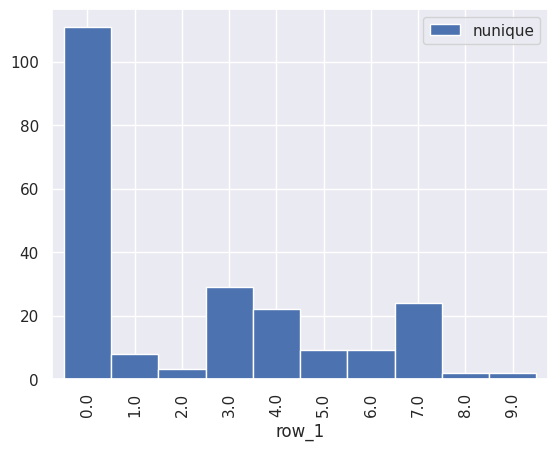

In [137]:
import seaborn as sns
sns.set()
# Are different feelings getting different meditations?

size_nunique_per_meditation = similarity_results.groupby('row_1')['labels'].agg(['nunique'])
size_nunique_per_meditation.plot(kind='bar', width=1)

In [141]:
# TODO: Create a appears-in-too-many-clusters disparity score. Consider the median point of each cluster each meditation appear. Use the cossine similarity between the different clusters to compute a single number.
# Reasoning: If it appears in similar clusters, it is ok. If it appears in two many different cluters, it is not ok.

# Scrapping meditations

In [22]:
import pandas as pd
from autoscraper import AutoScraper

model_url = 'https://media.sydevelopers.com/meditations/70/edit'

# We can add one or multiple candidates here.
# You can also put urls here to retrieve urls.
wanted_list = ['Morning meditation', 'general, happy, relaxed, content, morning, morning-general', "https://media.sydevelopers.com/meditations/c798b19f1c.json"]
scraper = AutoScraper()
result = scraper.build(model_url, wanted_list)
print(result)

# Retrieving exact information
meditations_data = pd.DataFrame(columns=['title', 'tags', 'data_url'])
for i in range(250):
    url = f'https://media.sydevelopers.com/meditations/{i}/edit'
    result = scraper.get_result_exact(url)
    if len(result) == 3:
        meditations_data.loc[i] = result
    else:
        print(f'{url}\n{result}')

# Saving the loot
meditations_data.reset_index().to_csv('meditation_descriptions_scrapped.csv', index=False)

['Morning meditation', 'general, happy, relaxed, content, morning, morning-general', 'https://media.sydevelopers.com/meditations/c798b19f1c', 'https://media.sydevelopers.com/meditations/c798b19f1c.json']


# !